#DJIA 30 Stock Time Series dataset
The script used to acquire all of the following data can be found in this GitHub repository. This repository also contains the modeling codes and will be updated continually, so welcome starring or watching!

Stock market data can be interesting to analyze and as a further incentive, strong predictive models can have large financial payoff. The amount of financial data on the web is seemingly endless. A large and well structured dataset on a wide array of companies can be hard to come by. Here provided a dataset with historical stock prices (last 12 years) for 29 of 30 DJIA companies (excluding 'V' because it does not have the whole 12 years data).

      ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 'GE',

      'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE',

      'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT', 'GOOGL', 'AMZN', 'AABA']

####Content
The data is presented in a couple of formats to suit different individual's needs or computational limitations.
I have included files containing 13 years of stock data (in the all_stocks_2006-01-01_to_2018-01-01.csv and corresponding folder) and
a smaller version of the dataset (all_stocks_2017-01-01_to_2018-01-01.csv) with only the past year's stock data for those wishing to use something more manageable in size.

The folder individual_stocks_2006-01-01_to_2018-01-01 contains files of data for individual stocks, labelled by their stock ticker name.
The all_stocks_2006-01-01_to_2018-01-01.csv and all_stocks_2017-01-01_to_2018-01-01.csv contain this same data, presented in merged .csv files.
Depending on the intended use (graphing, modelling etc.) the user may prefer one of these given formats.

All the files have the following columns:
Date - in format: yy-mm-dd

Open - price of the stock at market open (this is NYSE data so all in USD)

High - Highest price reached in the day

Low Close - Lowest price reached in the day

Volume - Number of shares traded

Name - the stock's ticker name

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import zipfile
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import math
from sklearn.metrics import mean_squared_error

In [ ]:
#@title Mount Google drive for datasets access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# def unzip_folder(zip_path, extract_path):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_path)

# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Neural_Architectures/DJIA_30_Stock_Time_Series/archive.zip'
# extract_directory = '/content/drive/MyDrive/Colab Notebooks/Neural_Architectures/DJIA_30_Stock_Time_Series'

# unzip_folder(zip_file_path, extract_directory)

In [ ]:
# First, we get the data
prefix_path = '/content/drive/MyDrive/IK_live_class/Datasets/'
dataset = pd.read_csv(prefix_path + 'DJIA_30_Stock_Time_Series/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [ ]:
# Checking for missing values
training_set = dataset[:'2017'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

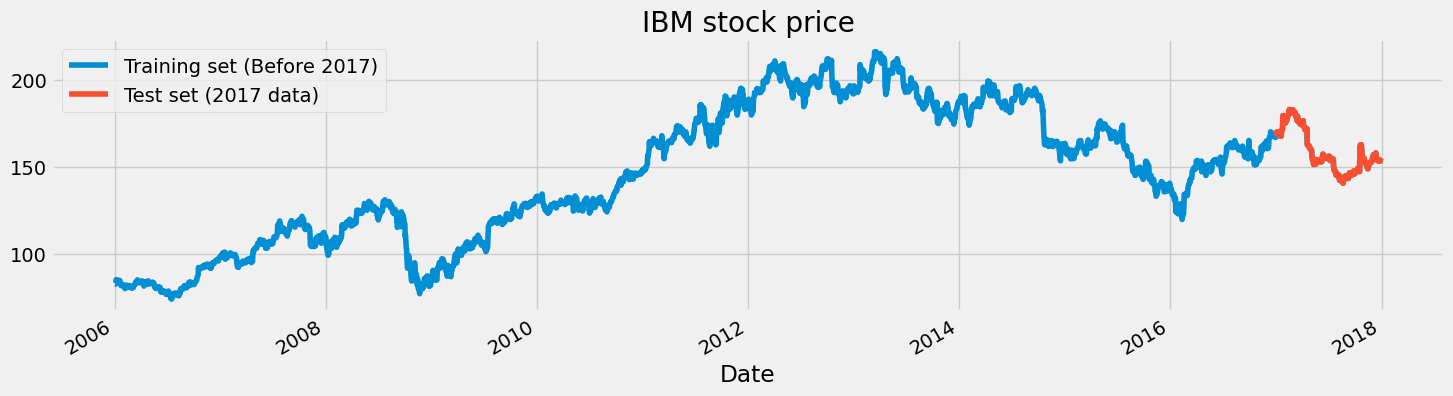

In [ ]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2017'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 data)'])
plt.title('IBM stock price')
plt.show()

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,3020):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
#@title The RNN architecture
import tensorflow as tf

# Initialize TPU strategy
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='TPU_0')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

# with strategy.scope():
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
93/93 [==============================] - 48s 139ms/step - loss: 0.0206
Epoch 2/50
93/93 [==============================] - 13s 139ms/step - loss: 0.0048
Epoch 3/50
93/93 [==============================] - 16s 174ms/step - loss: 0.0044
Epoch 4/50
93/93 [==============================] - 13s 135ms/step - loss: 0.0044
Epoch 5/50
93/93 [==============================] - 11s 115ms/step - loss: 0.0036
Epoch 6/50
93/93 [==============================] - 13s 138ms/step - loss: 0.0037
Epoch 7/50
93/93 [==============================] - 13s 139ms/step - loss: 0.0035
Epoch 8/50
93/93 [==============================] - 16s 169ms/step - loss: 0.0033
Epoch 9/50
93/93 [==============================] - 11s 114ms/step - loss: 0.0032
Epoch 10/50
93/93 [==============================] - 13s 136ms/step - loss: 0.0032
Epoch 11/50
93/93 [==============================] - 13s 139ms/step - loss: 0.0028
Epoch 12/50
93/93 [==============================] - 13s 139ms/step - loss: 0.0029
Epoch 13/50
9

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 0s 34ms/step


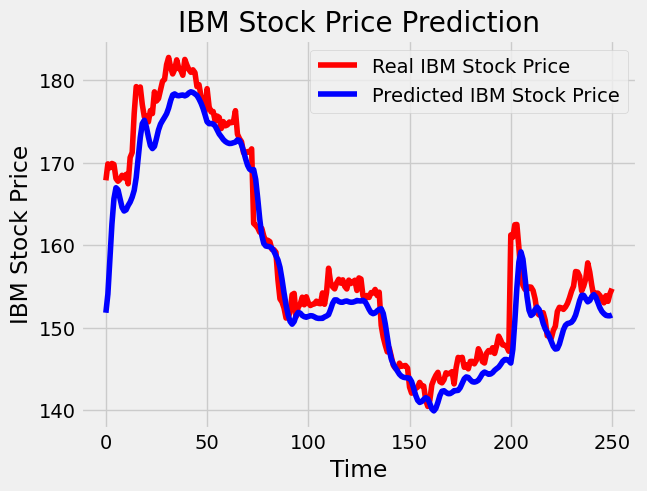

In [ ]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real IBM Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [ ]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 3.5953307561865144.


In [ ]:
import time
time.sleep(3600*3)

KeyboardInterrupt: ignored